# Pre-process ESA Snow CCI data

- Snow Cover Fraction Climate Research Data Package: http://snow-cci.enveo.at/
- summer path: `/mnt/lalandmi/equipes/C2H/ESA_CCI_SNOW`

Check missing values, linear interpolation on time, and spatial aggregation

conda env: `phd_v3`

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '/home/lalandmi/Dropbox/Thèse/notebooks/utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


In [2]:
# For parallelisation
from dask.distributed import Client
from dask import delayed
from dask import compute
client = Client(n_workers=4, threads_per_worker=3, memory_limit='4GB')
# client = Client()
client

Client Scheduler: tcp://127.0.0.1:41903 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 12 Memory: 16.00 GB


In [18]:
client.close()

In [3]:
path_snow_CCI = '/mnt/lalandmi/equipes/C2H/ESA_CCI_SNOW/dap.ceda.ac.uk/neodc/esacci/snow/data/scfg'
path_AVHRR = path_snow_CCI+'/AVHRR_MERGED/v2.0'
path_MODIS = path_snow_CCI+'/MODIS/v2.0'

In [4]:
ds = xr.open_mfdataset(path_AVHRR+'/1982/01/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0.nc', parallel=True)
ds

,Array,Chunk
Bytes,1.73 MB,57.60 kB
Shape,"(30, 3600, 2)","(1, 3600, 2)"
Count,120 Tasks,30 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,3.46 MB,115.20 kB
Shape,"(30, 7200, 2)","(1, 7200, 2)"
Count,120 Tasks,30 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [5]:
da = ds.scfg
da

,Array,Chunk
Bytes,3.11 GB,103.68 MB
Shape,"(30, 3600, 7200)","(1, 3600, 7200)"
Count,90 Tasks,30 Chunks
Type,float32,numpy.ndarray


In [6]:
scf = da.where(da <= 100)

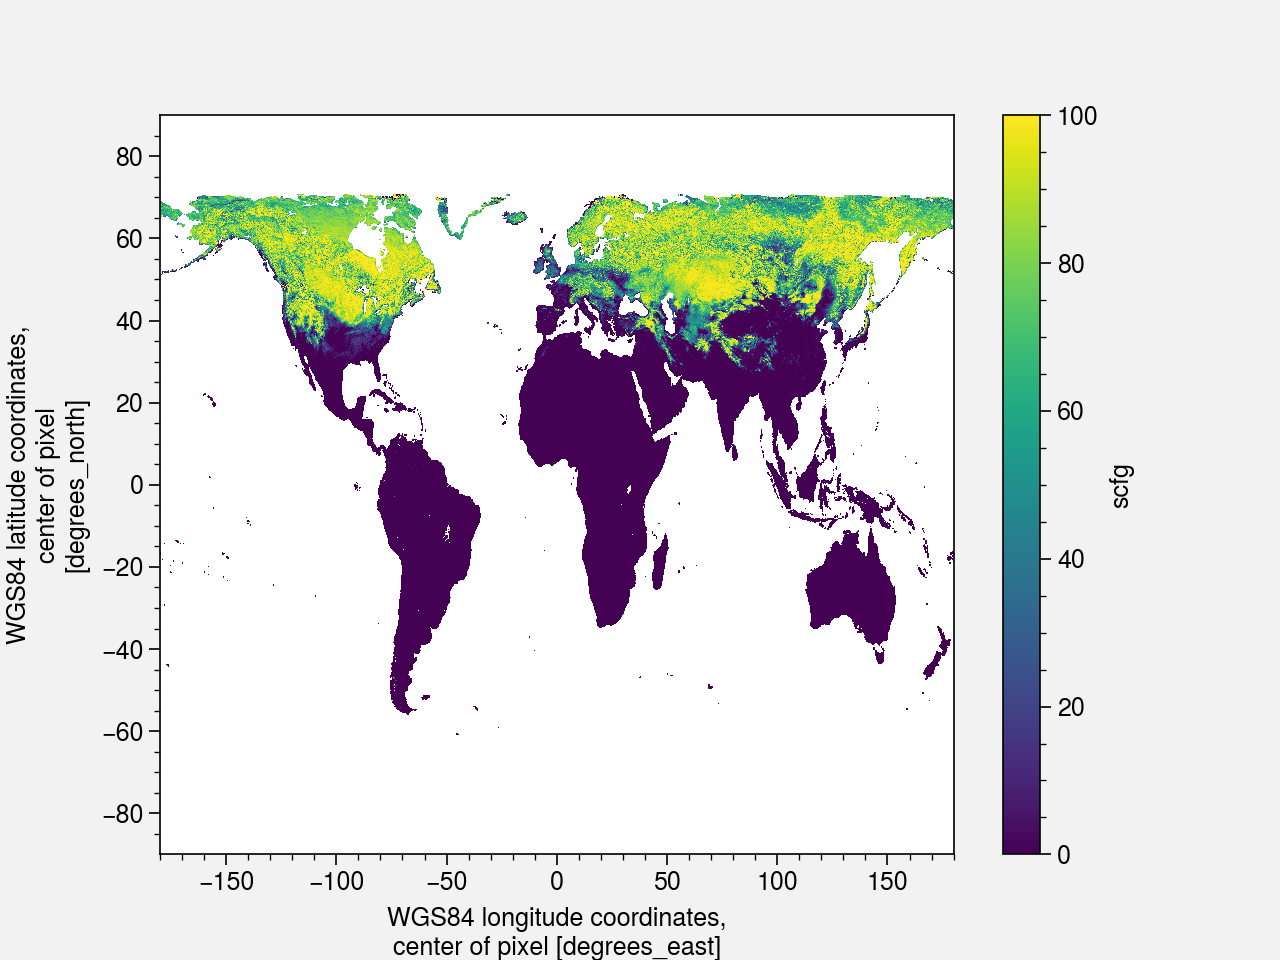

In [13]:
scf.mean('time').plot()

In [7]:
data_coverage = ((scf.count('time') / scf.time.size)*100).load()

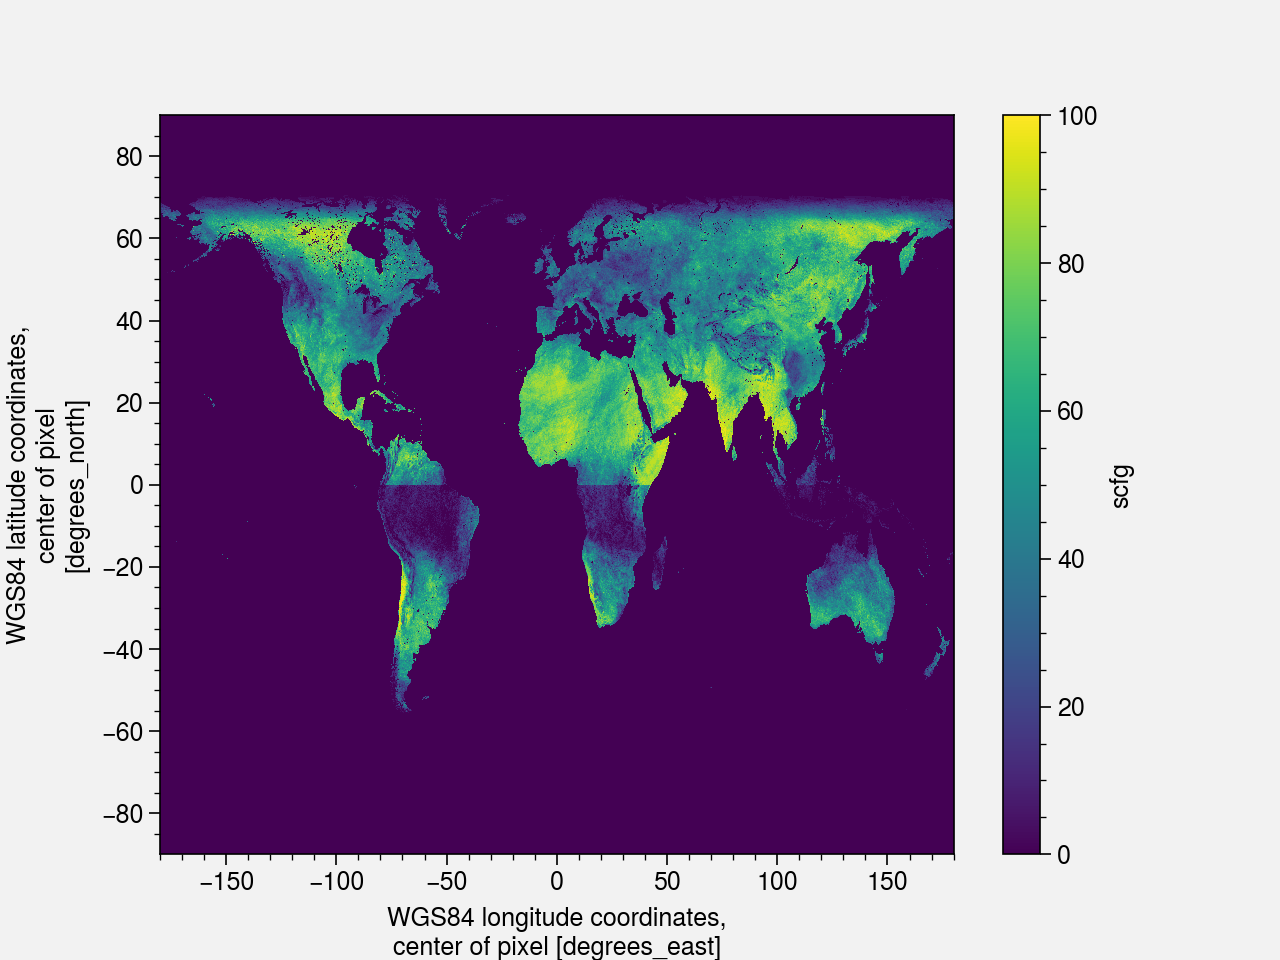

In [30]:
data_coverage.plot()

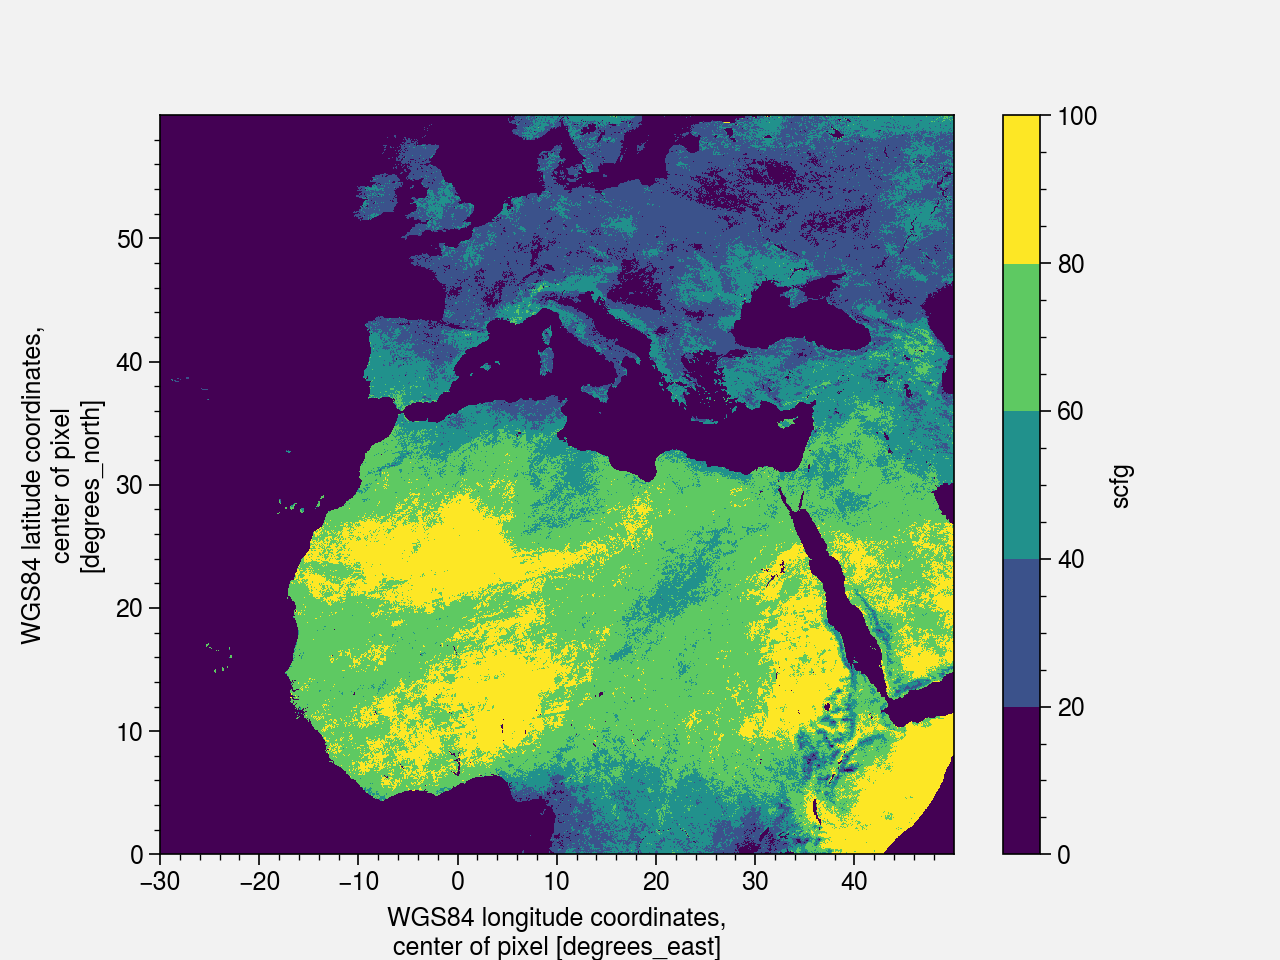

In [33]:
data_coverage.sel(lat=slice(0,60), lon=slice(-30, 50)).plot(levels=plot.arange(0, 100, 20))

## Linear temporal gapfill

In [11]:
scf

,Array,Chunk
Bytes,3.11 GB,103.68 MB
Shape,"(30, 3600, 7200)","(1, 3600, 7200)"
Count,150 Tasks,30 Chunks
Type,float32,numpy.ndarray


In [12]:
scf.chunk({'time': -1, 'lat':1000, 'lon':1000})

<xarray.DataArray 'scfg' (time: 30, lat: 3600, lon: 7200)>
dask.array<rechunk-merge, shape=(30, 3600, 7200), dtype=float32, chunksize=(30, 1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
  * lat      (lat) float64 -89.97 -89.93 -89.88 -89.82 ... 89.88 89.93 89.97
  * time     (time) datetime64[ns] 1982-01-01 1982-01-02 ... 1982-01-31
Attributes:
    long_name:            Snow Cover Fraction on Ground
    units:                percent
    standard_name:        surface_snow_area_fraction
    valid_range:          [  0 254]
    actual_range:         [  0 100]
    flag_values:          [205 206 210 215 254]
    flag_meanings:        Cloud Polar_Night_or_Night Water Permanent_Snow_and...
    grid_mapping:         spatial_ref
    ancillary_variables:  scfg_unc

In [14]:
scf_time_interp = scf.chunk({'time': -1, 'lat':1000, 'lon':1000}).interpolate_na('time', method='linear')
scf_time_interp

<xarray.DataArray 'scfg' (time: 30, lat: 3600, lon: 7200)>
dask.array<transpose, shape=(30, 3600, 7200), dtype=float64, chunksize=(30, 1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
  * lat      (lat) float64 -89.97 -89.93 -89.88 -89.82 ... 89.88 89.93 89.97
  * time     (time) datetime64[ns] 1982-01-01 1982-01-02 ... 1982-01-31
Attributes:
    long_name:            Snow Cover Fraction on Ground
    units:                percent
    standard_name:        surface_snow_area_fraction
    valid_range:          [  0 254]
    actual_range:         [  0 100]
    flag_values:          [205 206 210 215 254]
    flag_meanings:        Cloud Polar_Night_or_Night Water Permanent_Snow_and...
    grid_mapping:         spatial_ref
    ancillary_variables:  scfg_unc

In [15]:
scf_time_interp_coverage = ((scf_time_interp.count('time') / scf_time_interp.time.size)*100).load()

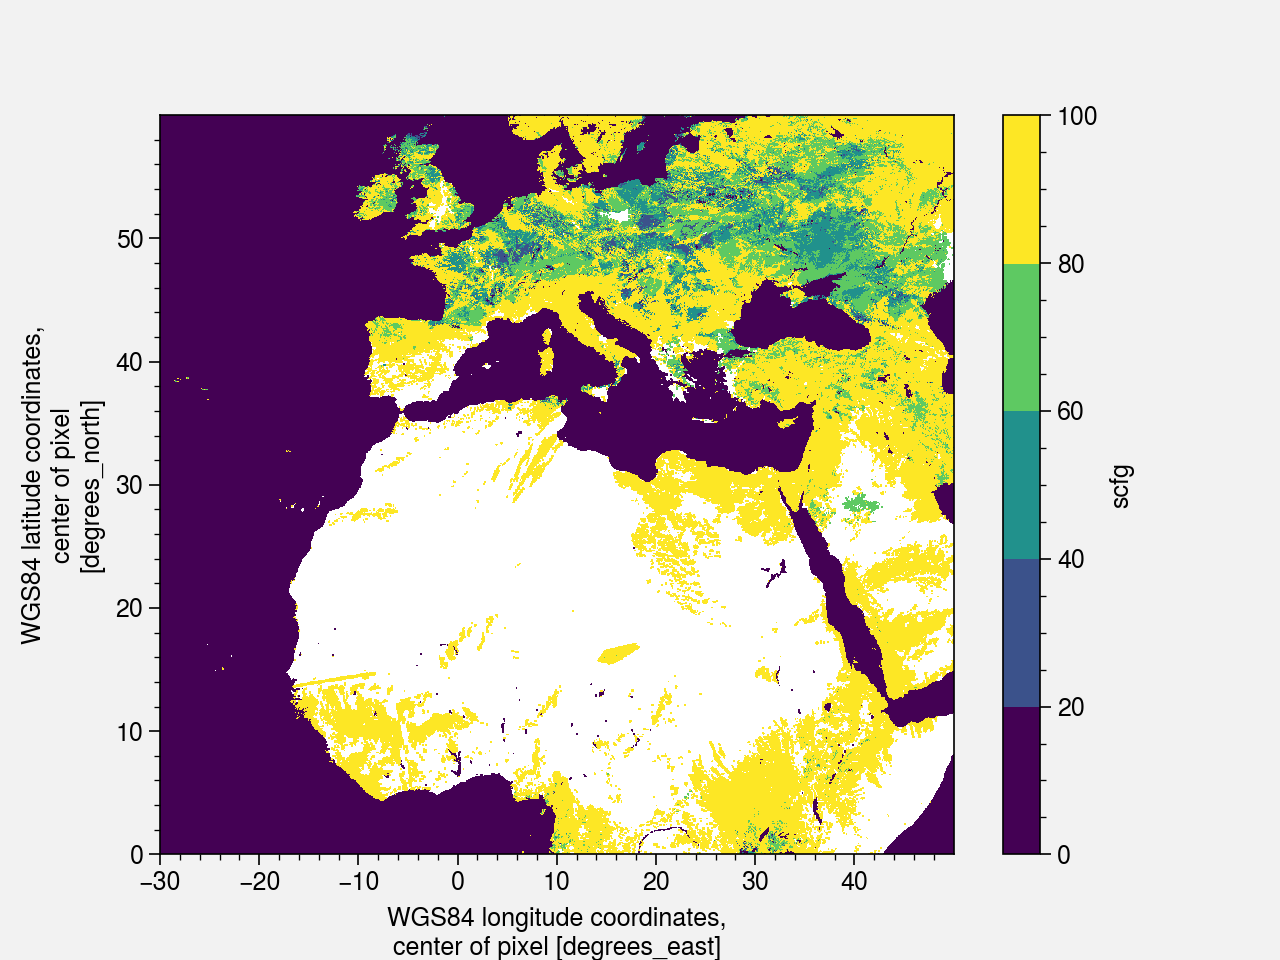

In [16]:
scf_time_interp_coverage.sel(lat=slice(0,60), lon=slice(-30, 50)).plot(levels=plot.arange(0, 100, 20))

In [17]:
clim_interp = scf_time_interp.mean('time').load()
clim = scf.mean('time').load()

KeyboardInterrupt: 

In [ ]:
clim_interp.sel(lat=slice(0,60), lon=slice(-30, 50)).plot(levels=plot.arange(0, 100, 20))

In [ ]:
clim.sel(lat=slice(0,60), lon=slice(-30, 50)).plot(levels=plot.arange(0, 100, 20))

In [ ]:
(clim_interp-clim).sel(lat=slice(0,60), lon=slice(-30, 50)).plot(levels=plot.arange(0, 100, 20))

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


## Spatial aggregation to 25km